## Regression

In [18]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from tkinter import *
from tkinter import ttk

### Dataset Definition

In [19]:
# first of all we should send a HTTP request to the server.
try:
    url = "https://www.scrapethissite.com/pages/simple/"
    response = requests.get(url)
except:
    print("Error!")

In [20]:
# then we should extract needed information from the HTML file.
soup = BeautifulSoup(response.text, "html.parser")

names = soup.find_all("h3", {"class": "country-name"})
populations = soup.find_all("span", {"class": "country-population"})
areas = soup.find_all("span", {"class": "country-area"})

for i in range(len(names)):
    names[i] = str(names[i].text.strip())
    populations[i] = int(populations[i].text.strip())
    areas[i] = float(areas[i].text.strip())

In [21]:
# now we create a data frame for the extracted information.
info = {
    "name": names,
    "population": populations,
    "area": areas
}
df = pd.DataFrame(info)
df.to_csv("country_info")

df.head()

,name,population,area
0,Andorra,84000,468.0
1,United Arab Emirates,4975593,82880.0
2,Afghanistan,29121286,647500.0
3,Antigua and Barbuda,86754,443.0
4,Anguilla,13254,102.0


### Preprocessing

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        250 non-null    object 
 1   population  250 non-null    int64  
 2   area        250 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.0+ KB


In [23]:
df.describe()

,population,area
count,2.500000e+02,2.500000e+02
mean,2.744568e+07,5.996369e+05
std,1.168626e+08,1.911821e+06
min,0.000000e+00,0.000000e+00
25%,1.798562e+05,1.174750e+03
50%,4.288138e+06,6.489450e+04
75%,1.542062e+07,3.726315e+05
max,1.330044e+09,1.710000e+07


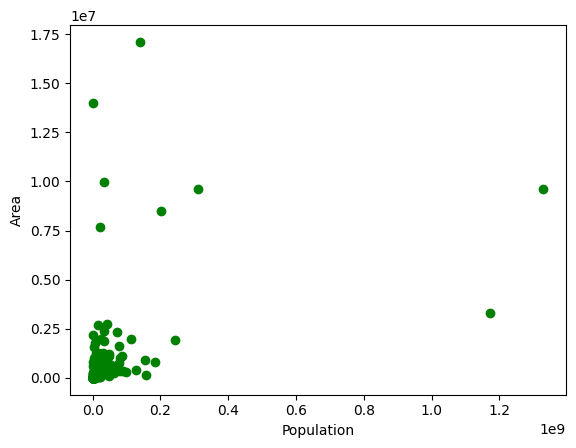

In [24]:
plt.scatter(df["population"], df["area"], color="green")
plt.xlabel("population".title())
plt.ylabel("area".title())
plt.show()

In [25]:
# We will now remove the outlier data points on "population" column.
Q3 = df["population"].quantile(0.75)
IQR = Q3
upper_bound = Q3 + 1.5 * IQR

df["population"] = df["population"].where(df["population"] < upper_bound, np.nan)

df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 218 entries, 0 to 249
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        218 non-null    object 
 1   population  218 non-null    float64
 2   area        218 non-null    float64
dtypes: float64(2), object(1)
memory usage: 6.8+ KB


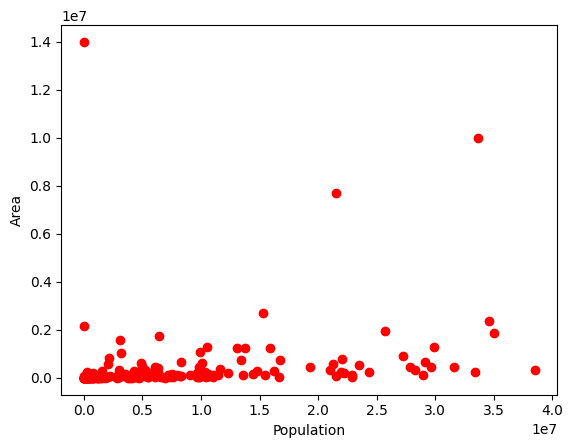

In [26]:
plt.scatter(df["population"], df["area"], color="red")
plt.xlabel("population".title())
plt.ylabel("area".title())
plt.show()

In [27]:
# We will now remove the outlier data points on "area" column.
Q3 = df["area"].quantile(0.75)
IQR = Q3

upper_bound = Q3 + 1.5 * IQR

df["area"] = df["area"].where(df["area"] < upper_bound, np.nan)

df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190 entries, 0 to 249
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        190 non-null    object 
 1   population  190 non-null    float64
 2   area        190 non-null    float64
dtypes: float64(2), object(1)
memory usage: 5.9+ KB


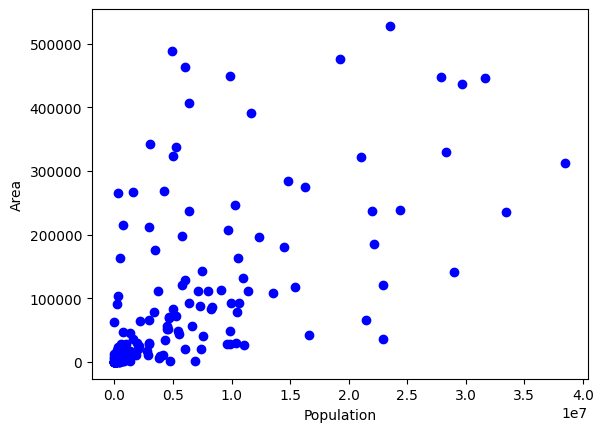

In [28]:
plt.scatter(df["population"], df["area"], color="blue")
plt.xlabel("population".title())
plt.ylabel("area".title())
plt.show()

In [29]:
# split data to train and test
msk = np.random.rand(len(df)) < 0.8

train, test = df[msk], df[~msk]

train.shape, test.shape

((151, 3), (39, 3))

### Model Definition

In [30]:
mymodel = DecisionTreeRegressor(max_depth=4)

x_train = np.asanyarray(train[["population"]])
y_train = np.asanyarray(train[["area"]])

mymodel.fit(x_train, y_train.ravel())

,criterion,'squared_error'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


### Model Evaluation

In [31]:
x_test = np.asanyarray(test[["population"]])
y_test = np.asanyarray(test[["area"]])

y_pred = mymodel.predict(x_test)

In [32]:
# The R2 score is quite low, indicating that the model has very low accuracy
mse = np.mean((y_test - y_pred) ** 2)
mae = np.mean(np.absolute(y_test - y_pred))
r2 = r2_score(y_test, y_pred)

print(f"mean squared error : {mse:.5f} | mean absolute error : {mae:.5f} | r2 score : {r2:.5f}")

mean squared error : 16452307118.26726 | mean absolute error : 90057.10986 | r2 score : 0.30273


In [33]:
def predict_area():
    try:
        x = int(entry.get())
        y = mymodel.predict([[x]])
        label_result.config(text=f"our prediction : {y[0]:.5f}")
    except:
        label_result.config(text="Invalid Input!")

root = Tk()
root.title("Area Predictor")
frm = ttk.Frame(root, padding=10) # Padding specifies the space between the widget and outer edges.
frm.grid()
label_1 = ttk.Label(frm, text="population : ").grid(row=0, column=0, pady=(0, 10))
entry = ttk.Entry(frm)
entry.grid(row=0, column=1, pady=(0, 10)) # The pady parameter defines the vertical spacing between rows
ttk.Button(frm, text="Predict", width=40, command=predict_area).grid(row=1, column=1)
label_result = ttk.Label(frm, text="our prediction ... ")
label_result.grid(row=2, column=0, pady=(0, 10))
ttk.Button(frm, text="Done",width=40, command=root.destroy).grid(row=3, column=1)
root.mainloop()